In [11]:
import torch
import os
import sys
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS
from tqdm import tqdm

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from util import *
from model.fls import FLS

In [12]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA available: True
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 Ti


In [13]:
# set seeds and configure cuda device
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [ ]:
class PDEData(Dataset):
    
    def __init__(self, x_range, t_range, x_points, t_points):
        self.device = device
        self.x_range = x_range
        self.t_range = t_range
        self.x_points = x_points
        self.t_points = t_points
        
        # Generate the data
        self.res, self.b_left, self.b_right, self.b_upper, self.b_lower = self._generate_data()
        
        # Convert to tensors and move to the specified device
        self.res = torch.tensor(self.res, dtype=torch.float32, requires_grad=True).to(self.device)
        self.b_left = torch.tensor(self.b_left, dtype=torch.float32, requires_grad=True).to(self.device)
        self.b_right = torch.tensor(self.b_right, dtype=torch.float32, requires_grad=True).to(self.device)
        self.b_upper = torch.tensor(self.b_upper, dtype=torch.float32, requires_grad=True).to(self.device)
        self.b_lower = torch.tensor(self.b_lower, dtype=torch.float32, requires_grad=True).to(self.device)
    

    def _generate_data(self):
        x = np.linspace(self.x_range[0], self.x_range[1], self.x_points)
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)
        
        x_mesh, t_mesh = np.meshgrid(x, t)
        data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
        
        b_left = data[0, :, :] 
        b_right = data[-1, :, :]
        b_upper = data[:, -1, :]
        b_lower = data[:, 0, :]
        res = data.reshape(-1, 2)

        return res, b_left, b_right, b_upper, b_lower
    
    def analytical_solution(self, x, t):
        """
        Compute the analytical solution u_ana(x, t).
        """
        h = torch.exp(- (x - torch.pi)**2 / (2 * (torch.pi / 4)**2))
        return h * torch.exp(5 * t) / (h * torch.exp(5 * t) + 1 - h)
    
    def get_interior_points(self):
        """
        Get the interior points (x_res, t_res).
        """
        x_res, t_res = self.res[:, 0:1], self.res[:, 1:2]
        return x_res, t_res
    
    def get_initial_condition(self):
        """
        Compute the initial condition u(x, t=0).
        """
        x_left, t_left = self.b_left[:, 0:1], self.b_left[:, 1:2]
        return self.analytical_solution(x_left, t_left)
    
    def get_boundary_points(self):
        """
        Get the boundary points (x_left, t_left, etc.).
        
        Returns:
            x_left, t_left, x_right, t_right, x_upper, t_upper, x_lower, t_lower
        """
        x_left, t_left = self.b_left[:, 0:1], self.b_left[:, 1:2]
        x_right, t_right = self.b_right[:, 0:1], self.b_right[:, 1:2]
        x_upper, t_upper = self.b_upper[:, 0:1], self.b_upper[:, 1:2]
        x_lower, t_lower = self.b_lower[:, 0:1], self.b_lower[:, 1:2]
        return x_left, t_left, x_right, t_right, x_upper, t_upper, x_lower, t_lower
    
    def get_boundary_values(self):
        """
        Compute the boundary values for the left, right, upper, and lower boundaries.
        """
        x_left, t_left, x_right, t_right, x_upper, t_upper, x_lower, t_lower = self.get_boundary_points()
        
        u_left = self.analytical_solution(x_left, t_left)
        u_right = self.analytical_solution(x_right, t_right)
        u_upper = self.analytical_solution(x_upper, t_upper)
        u_lower = self.analytical_solution(x_lower, t_lower)
        
        return u_left, u_right, u_upper, u_lower
    
    def get_test_points(self):
        """
        Get the test points (res_test) and their spatial and temporal components.
        
        Returns:
            res_test (torch.Tensor): Test points as a tensor.
            x_test, t_test (torch.Tensor): Spatial and temporal components of the test points.
        """
        res_test = self.res.clone()  # Use the same res points for testing
        x_test, t_test = res_test[:, 0:1], res_test[:, 1:2]
        return res_test, x_test, t_test

In [5]:
# Train PINNs 
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
model = FLS(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

C:\Users\prdie\AppData\Local\Temp\ipykernel_30032\3301805935.py:4: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


FLS(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): SinAct()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


In [ ]:
# Create the dataset
dataset = PDEData(x_range=[0, 2 * np.pi], t_range=[0, 1], x_points=101, t_points=101)

# Get interior points
x_res, t_res = dataset.get_interior_points()

# Get boundary values
x_left, t_left, x_right, t_right, x_upper, t_upper, x_lower, t_lower = dataset.get_boundary_points()    
u_left, u_right, u_upper, u_lower = dataset.get_boundary_values()

# Training loop
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        # Compute derivatives
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        # Compute losses
        loss_res = torch.mean((u_t - 5 * pred_res * (1 - pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:, 0] - u_left[:, 0]) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward(retain_graph=True)
        return loss

    optim.step(closure)

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\prdie\OneDrive\Sources\pinnsformer\gnn_project\gnn_project_env\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 500/500 [05:47<00:00,  1.44it/s]


In [7]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_fls_extended.pt')

Loss Res: 0.019518, Loss_BC: 0.000001, Loss_IC: 0.179613
Train Loss: 0.199132


relative L1 error: 0.981506
relative L2 error: 0.979435


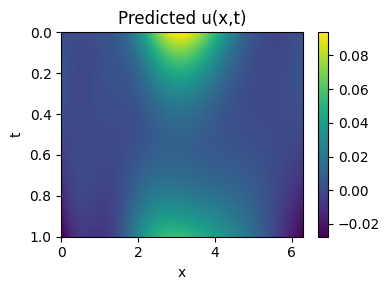

In [8]:
# Get test points from the dataset
res_test, x_test, t_test = dataset.get_test_points()

# Compute the analytical solution for the test points
u_analytical = dataset.analytical_solution(x_test, t_test).cpu().detach().numpy().reshape(101, 101)

# Convert test points to PyTorch tensors
res_test = res_test.to(device)

# Model predictions
with torch.no_grad():
    pred = model(x_test.to(device), t_test.to(device))[:, 0:1]
    pred = pred.cpu().detach().numpy().reshape(101, 101)

# Compute relative errors
rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

# Visualization
plt.figure(figsize=(4, 3))
plt.imshow(pred, extent=[0, np.pi * 2, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_fls_pred_extended.png')
plt.show()

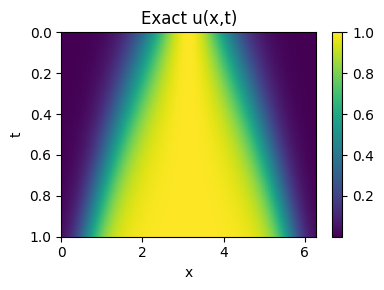

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(u_analytical, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact_extended.png')
plt.show()

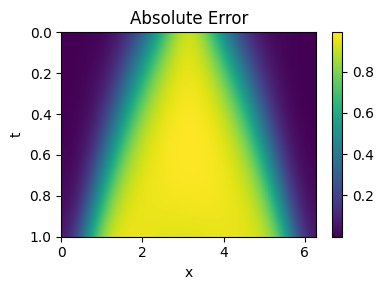

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u_analytical), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_fls_error_extended.png')
plt.show()